In [ ]:
import os
import cv2
import face_recognition
import math
import numpy as np
import json
import time
from collections import defaultdict

# Helper: convert raw face distance into a confidence percentage
def face_confidence(face_distance, face_match_threshold=0.45):
    value_range = (1.0 - face_match_threshold)
    linear_val = (1.0 - face_distance) / (value_range * 2.0)
    if face_distance > face_match_threshold:
        return f"{round(linear_val * 100, 2)}%"
    value = (linear_val + ((1.0 - linear_val) * math.pow((linear_val - 0.5) * 2, 0.2))) * 100
    return f"{round(value, 2)}%"

class FaceRecognition:
    def __init__(self):
        # --- Core data structures ---
        self.face_locations = []
        self.face_encodings = []
        self.face_names = []
        self.known_face_encodings = []
        self.known_face_names = []

        # --- Tuning parameters ---
        self.face_detection_model = "hog"      # CPU-friendly
        self.recognition_tolerance = 0.45      # Lower = stricter
        self.maybe_tolerance    = 0.55
        self.confidence_threshold = 60.0       # %
        self.face_history       = defaultdict(list)
        self.history_size       = 10
        self.consistency_threshold = 0.8       # 80% of recent frames
        self.angle_verification = True
        self.last_recognition_time = {}

        # --- Determine script directory safely ---
        try:
            self.script_dir = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            self.script_dir = os.getcwd()

        # --- Ensure faces/ exists ---
        faces_dir = os.path.join(self.script_dir, "faces")
        os.makedirs(faces_dir, exist_ok=True)
        print(f"📁 faces/ directory: {faces_dir}")

        # --- Load metadata & encode known faces ---
        self.people_data = {}
        self.load_people_data()
        self.encode_faces()

    def load_people_data(self):
        """Load (or create) people_data.json with extra info."""
        json_path = os.path.join(self.script_dir, "people_data.json")
        if not os.path.exists(json_path):
            print("📄 Creating template people_data.json...")
            template = {
                "John":  {"Title":"Professor","Department":"Computer Science","Major":"AI","Graduate":"Yes"},
                "Alice": {"Title":"Student","Department":"Engineering","Major":"Robotics","Graduate":"No"}
            }
            with open(json_path, "w", encoding="utf-8") as f:
                json.dump(template, f, indent=4, ensure_ascii=False)
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                self.people_data = json.load(f)
            print(f"✅ Loaded info for {len(self.people_data)} people")
        except Exception as e:
            print(f"⚠️ Error reading people_data.json: {e}")
            self.people_data = {}

    def encode_faces(self):
        """Scan faces/ folder and build known_face_encodings."""
        print("📂 Scanning faces/ for images…")
        faces_dir = os.path.join(self.script_dir, "faces")
        files = [f for f in os.listdir(faces_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
        if not files:
            print("⚠️ No images in faces/. Add name_number.jpg files and rerun.")
            return

        for fname in files:
            path = os.path.join(faces_dir, fname)
            img = cv2.imread(path)
            if img is None:
                print(f"⚠️ Cannot read {fname}")
                continue
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            locs = face_recognition.face_locations(rgb, model=self.face_detection_model)
            if not locs:
                print(f"⚠️ No face found in {fname}")
                continue
            encs = face_recognition.face_encodings(rgb, locs, num_jitters=5)
            if not encs:
                print(f"⚠️ Failed to encode {fname}")
                continue
            name = os.path.splitext(fname)[0].split("_")[0]
            for e in encs:
                self.known_face_encodings.append(e)
                self.known_face_names.append(name)
            print(f"✅ Encoded {len(encs)} face(s) for '{name}'")

        print(f"🎉 Total known faces: {len(self.known_face_encodings)}")

    def verify_face_consistency(self, loc, name):
        """Require a face to appear consistently over several frames."""
        top, right, bottom, left = loc
        center = ((left+right)//2, (top+bottom)//2)
        size   = (right-left)*(bottom-top)

        # match to existing history key
        key = next((k for k,v in self.face_history.items()
                    if abs(v[-1][0][0]-center[0])<50 and abs(v[-1][0][1]-center[1])<50), None)
        if key is None:
            key = len(self.face_history)
        self.face_history[key].append((center, size, name))
        if len(self.face_history[key])>self.history_size:
            self.face_history[key].pop(0)

        if len(self.face_history[key])<5:
            return False
        names = [n for _,_,n in self.face_history[key]]
        cons  = names.count(name)/len(names)
        if cons>=self.consistency_threshold:
            self.last_recognition_time[name] = time.time()
            return True
        return False

    def verify_with_multiple_models(self, frame, loc, name):
        """Re-encode region with higher jitters as cross-check."""
        t,r,b,l = loc
        t,r,b,l = max(0,t-20), min(frame.shape[1],r+20), min(frame.shape[0],b+20), max(0,l-20)
        sub = frame[t:b, l:r]
        if sub.size==0: return False
        rgb = cv2.cvtColor(sub, cv2.COLOR_BGR2RGB)
        encs = face_recognition.face_encodings(rgb, [(0,r-b,r,l)], num_jitters=10)
        if not encs: return False
        matches = face_recognition.compare_faces(
            self.known_face_encodings, encs[0], tolerance=self.recognition_tolerance-0.05)
        matched = [self.known_face_names[i] for i,m in enumerate(matches) if m]
        return matched.count(name)/max(1,len(matched))>=0.7

    def run_recognition(self):
        """Open webcam, detect & label faces in real time."""
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("❌ Webcam not available"); return

        print("🎥 Press 'q' to quit.")
        cnt = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            cnt += 1
            small = cv2.resize(frame, (0,0), fx=0.5, fy=0.5)
            rgb   = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)

            if cnt%2==0:
                locs = face_recognition.face_locations(rgb, model=self.face_detection_model)
                encs = face_recognition.face_encodings(rgb, locs, num_jitters=3)
                self.face_locations, self.face_encodings, self.face_names = [],[],[]

                for i,e in enumerate(encs):
                    dists   = face_recognition.face_distance(self.known_face_encodings, e)
                    idx     = np.argmin(dists) if len(dists)>0 else None
                    name    = "Unknown"; conf="???"
                    if idx is not None:
                        conf = face_confidence(dists[idx])
                        if (dists[idx] <= self.recognition_tolerance
                            and float(conf.strip("%"))>=self.confidence_threshold):
                            name = self.known_face_names[idx]
                            if not self.verify_face_consistency(locs[i],name):
                                name = f"Verifying {name}"
                            elif self.angle_verification and not self.verify_with_multiple_models(frame, [t*2 for t in locs[i]], name):
                                name = f"Validating {name}"
                    self.face_locations.append(locs[i])
                    self.face_names.append(f"{name} ({conf})")

            # draw
            for (t,r,b,l), label in zip(self.face_locations, self.face_names):
                t,r,b,l = t*2,r*2,b*2,l*2
                cv2.rectangle(frame,(l,t),(r,b),(0,255,0),2)
                cv2.putText(frame,label,(l,b+20),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)

            cv2.imshow("Face Recognition", frame)
            if cv2.waitKey(1)&0xFF==ord("q"):
                break

        cap.release()
        cv2.destroyAllWindows()

# === Runner ===
if __name__=="__main__":
    print("🚀 Launching Face Recognition…")
    fr = FaceRecognition()
    fr.run_recognition()


🚀 Launching Face Recognition…
📁 faces/ directory: /content/faces
✅ Loaded info for 2 people
📂 Scanning faces/ for images…
⚠️ No images in faces/. Add name_number.jpg files and rerun.
❌ Webcam not available


In [ ]:
from google.colab.output import eval_js
import cv2, numpy as np
from base64 import b64decode

def take_photo(quality=0.8):
    js = """
    async function capture(){
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      const video  = document.createElement('video');
      video.srcObject = stream;
      await video.play();
      const canvas = document.createElement('canvas');
      canvas.width  = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(t=>t.stop());
      return canvas.toDataURL('image/jpeg', %f);
    }
    capture();
    """ % quality
    data = eval_js(js)              # run the string of JS
    header, encoded = data.split(',', 1)
    return cv2.imdecode(            # decode JPEG bytes to OpenCV image
      np.frombuffer(b64decode(encoded), np.uint8),
      cv2.IMREAD_COLOR
    )


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

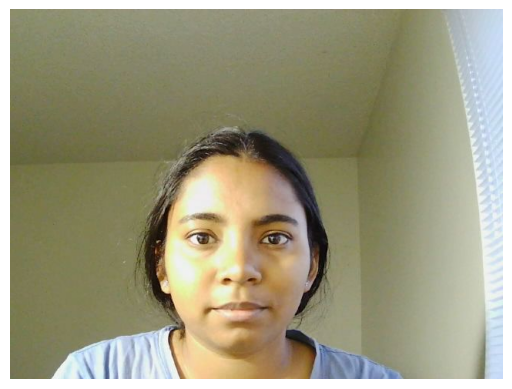

In [ ]:
frame = take_photo()
# in Colab you can’t cv2.imshow, so use matplotlib:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [ ]:
# Force dlib to use CPU only
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [ ]:
!pip install --upgrade --force-reinstall --no-binary dlib dlib
!pip install --upgrade --force-reinstall face_recognition opencv-python-headless

  Using cached dlib-19.24.8-cp311-cp311-linux_x86_64.whl
  Attempting uninstall: dlib
    Found existing installation: dlib 19.24.8
    Uninstalling dlib-19.24.8:
      Successfully uninstalled dlib-19.24.8


  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached face_recognition_models-0.3.0-py2.py3-none-any.whl
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached dlib-19.24.8-cp311-cp311-linux_x86_64.whl
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pillow-11.2.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached pillow-11.2.1-cp311-cp311-manylinux_2_28_x86_64.whl (4.6 MB)
  Attempting uninstall: face-reco

In [ ]:
# ─── Cell 1: Install dependencies ──────────────────────────────────────────
!apt-get update -qq
!apt-get install -y cmake build-essential
!pip install dlib face_recognition opencv-python-headless

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

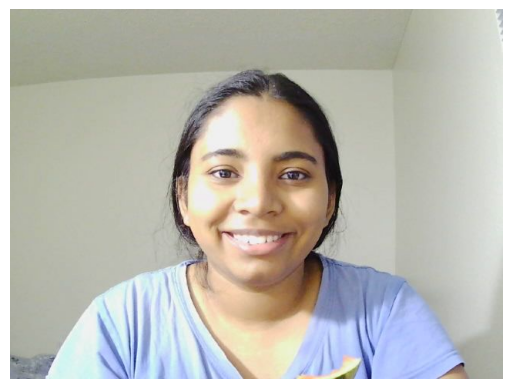

In [ ]:
# ─── Cell 2: JS helper to grab one webcam frame ────────────────────────────
from google.colab.output import eval_js
import cv2, numpy as np
from base64 import b64decode
from matplotlib import pyplot as plt

def take_photo(quality=0.8):
    js = """
    async function capture(){
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      const video  = document.createElement('video');
      video.srcObject = stream;
      await video.play();
      const canvas = document.createElement('canvas');
      canvas.width  = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(t=>t.stop());
      return canvas.toDataURL('image/jpeg', %f);
    }
    capture();
    """ % quality
    data = eval_js(js)  # returns "data:image/jpeg;base64,...."
    header, encoded = data.split(',', 1)
    img = cv2.imdecode(
        np.frombuffer(b64decode(encoded), np.uint8),
        cv2.IMREAD_COLOR
    )
    return img

# Quick test
frame = take_photo()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); plt.axis('off')


In [ ]:
# ─── Cell 3: Modified FaceRecognition class ────────────────────────────────
import os, math, time, json
import cv2, face_recognition, numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

def face_confidence(face_distance, face_match_threshold=0.45):
    vr = (1.0 - face_match_threshold)
    lv = (1.0 - face_distance) / (vr * 2.0)
    if face_distance > face_match_threshold:
        return f"{round(lv*100,2)}%"
    v = (lv + ((1-lv)*math.pow((lv-0.5)*2,0.2)))*100
    return f"{round(v,2)}%"

class FaceRecognition:
    def __init__(self, faces_dir="faces", tol=0.45):
        self.tol = tol
        os.makedirs(faces_dir, exist_ok=True)
        self.faces_dir = faces_dir
        self.known_encs, self.known_names = [], []
        self._load_and_encode()

    def _load_and_encode(self):
        files = [f for f in os.listdir(self.faces_dir) if f.lower().endswith((".jpg",".png"))]
        for f in files:
            img = cv2.imread(os.path.join(self.faces_dir,f))
            if img is None: continue
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            locs = face_recognition.face_locations(rgb, model="hog")
            encs = face_recognition.face_encodings(rgb, locs, num_jitters=3)
            name = os.path.splitext(f)[0].split("_")[0]
            for e in encs:
                self.known_encs.append(e); self.known_names.append(name)

    def process_frame(self, frame):
        rgb  = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        locs = face_recognition.face_locations(rgb, model="hog")
        encs = face_recognition.face_encodings(rgb, locs)
        for (t,r,b,l), enc in zip(locs, encs):
            dists = face_recognition.face_distance(self.known_encs, enc)
            if len(dists)>0:
                i = np.argmin(dists)
                conf = float(face_confidence(dists[i]).strip("%"))
                name = self.known_names[i] if (dists[i]<=self.tol and conf>=60) else "Unknown"
            else:
                name="Unknown"
            cv2.rectangle(frame,(l,t),(r,b),(0,255,0),2)
            cv2.putText(frame, name, (l,b+20), cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),2)
        return frame

# Load known faces (you should upload a `faces/` folder to Colab with your images)
fr = FaceRecognition(faces_dir="faces")


In [ ]:
# ─── Cell 4: Grab a photo, run recognition, and display ───────────────────
frame = take_photo()
annotated = fr.process_frame(frame.copy())
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')


RuntimeError: Error while calling cudaOccupancyMaxPotentialBlockSize(&num_blocks,&num_threads,K) in file /tmp/.tmplhoiAU/sdists-v9/pypi/dlib/19.24.6/myhuNI8MNAU5FPqAHNVyi/src/dlib/cuda/cuda_utils.h:186. code: 222, reason: the provided PTX was compiled with an unsupported toolchain.